In [3]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

In [4]:
#clear df
import gc

for var in list(globals()):
    if var.startswith('df'):
        del globals()[var]

gc.collect()

20

In [5]:

df = pd.read_parquet('df_final_v2.parquet')

print(df.shape)

(15600, 19)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  15600 non-null  datetime64[ns]
 1   zone_id                   15600 non-null  int64         
 2   mta_flow                  15600 non-null  float64       
 3   taxi_flow                 15600 non-null  float64       
 4   trip_distance             15600 non-null  float64       
 5   fare_amount               15600 non-null  float64       
 6   has_congestion_surcharge  15600 non-null  float64       
 7   temp                      15600 non-null  float64       
 8   prcp                      15600 non-null  float64       
 9   coco                      15600 non-null  float64       
 10  coco_group                15600 non-null  object        
 11  total_flow                15600 non-null  float64       
 12  hour              

In [7]:
# import pandas as pd
# df_onehot = pd.read_parquet('df_final_filtered_onehot.parquet')

# print(df_onehot.shape)

In [8]:
#After observing data, decide to use log to the target 'total_flow'
# log_transformation for linear Regression
df['log_total_flow'] = np.log1p(df['total_flow'])
df['log_mta_flow'] = np.log1p(df['mta_flow'])
df['log_taxi_flow'] = np.log1p(df['taxi_flow'])

In [9]:
df2 = df.copy()
# df2 會拿來做one-hot 之後用RF可以重用df

In [10]:
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['month'] = df2['datetime'].dt.month

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  15600 non-null  datetime64[ns]
 1   zone_id                   15600 non-null  int64         
 2   mta_flow                  15600 non-null  float64       
 3   taxi_flow                 15600 non-null  float64       
 4   trip_distance             15600 non-null  float64       
 5   fare_amount               15600 non-null  float64       
 6   has_congestion_surcharge  15600 non-null  float64       
 7   temp                      15600 non-null  float64       
 8   prcp                      15600 non-null  float64       
 9   coco                      15600 non-null  float64       
 10  coco_group                15600 non-null  object        
 11  total_flow                15600 non-null  float64       
 12  hour              

In [12]:
#Split the dataset into two datasets:
#Train Feb + Jun
#Test  Sep + Dec
train_df = df2[df2['month'].isin([2,6])]
test_df = df2[df2['month'].isin([9,12])]

print("Train size: ", len(train_df))
print("Test size: ", len(test_df))

Train size:  7670
Test size:  7930


In [13]:
categorical_cols = ['hour', 'weekday', 'month', 'coco_group', 'is_weekend', 'zone_id']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

In [14]:
continuous_cols = [
    'log_mta_flow', 'log_taxi_flow',
    'fare_amount', 'has_congestion_surcharge',
    'lat','lon',
    'zone_avg_flow',
    'temp', 'prcp'
]
# y = log_total_flow
# categorical_cols = [
#     col for col in train_df.columns if col.startswith('hour_') or
#                                 col.startswith('weekday_') or
#                                 col.startswith('condition_') or
#                                 col.startswith('zone_') or
#                                 col.startswith('cocogroup_') or
#                                 col.startswith('weather_')
# ]
categorical_base = ['hour', 'weekday', 'month', 'coco_group', 'is_weekend', 'zone_id']
categorical_cols = [col for col in train_df.columns if any(col.startswith(prefix + "_") for prefix in categorical_base)]


In [15]:
all_cols = continuous_cols + categorical_cols

In [16]:
# ensure test and train set align
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

### 1. Linear Regression

In [18]:
# X_cont_train, X_cont_test, y_train, y_test = train_test_split(df[continuous_cols], y, test_size=0.2, random_state=42)
# X_cat_train, X_cat_test, _ , _ = train_test_split(df_cat, y, test_size=0.2, random_state=42)2

In [19]:
#continuous_col
X_train_cont = train_df[continuous_cols]
X_test_cont = test_df[continuous_cols]

#categorical_col
X_train_cat = train_df[categorical_cols]
X_test_cat = test_df[categorical_cols]

#all_col
X_train_all = train_df[all_cols]
X_test_all = test_df[all_cols]

# Target variable with log
y_train = train_df['log_total_flow']
y_test = test_df['log_total_flow']

In [20]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, 7670 to 15599
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   hour_10                      7930 non-null   bool 
 1   hour_11                      7930 non-null   bool 
 2   hour_12                      7930 non-null   bool 
 3   hour_13                      7930 non-null   bool 
 4   hour_14                      7930 non-null   bool 
 5   hour_15                      7930 non-null   bool 
 6   hour_16                      7930 non-null   bool 
 7   hour_17                      7930 non-null   bool 
 8   hour_18                      7930 non-null   bool 
 9   weekday_1                    7930 non-null   bool 
 10  weekday_2                    7930 non-null   bool 
 11  weekday_3                    7930 non-null   bool 
 12  weekday_4                    7930 non-null   bool 
 13  weekday_5                    7930 non-null   bool

In [21]:
X_test_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, 7670 to 15599
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   log_mta_flow              7930 non-null   float64
 1   log_taxi_flow             7930 non-null   float64
 2   fare_amount               7930 non-null   float64
 3   has_congestion_surcharge  7930 non-null   float64
 4   lat                       7930 non-null   float64
 5   lon                       7930 non-null   float64
 6   zone_avg_flow             7930 non-null   float64
 7   temp                      7930 non-null   float64
 8   prcp                      7930 non-null   float64
dtypes: float64(9)
memory usage: 619.5 KB


#### 1-2 continuous features

##### 1-2-1 simple linear regression

In [22]:
y = train_df['log_total_flow']

print("\nDescriptive features in X:\n", X_test_cont)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
        log_mta_flow  log_taxi_flow  fare_amount  has_congestion_surcharge  \
7670       8.731175       6.289716    24.213222                  0.833849   
7671       7.566828       5.463832    15.662782                  0.907954   
7672       8.873748       5.986452    15.889405                  0.891608   
7673       7.507141       1.945910    25.385000                  0.750000   
7674       6.350886       2.197225    31.100000                  1.000000   
...             ...            ...          ...                       ...   
15595      8.980676       0.000000     0.000000                  0.000000   
15596      9.099409       0.000000     0.000000                  0.000000   
15597      7.544861       0.000000     0.000000                  0.000000   
15598      8.970813       0.000000     0.000000                  0.000000   
15599      8.778788       0.000000     0.000000                  0.000000   

           lat      lon  zone_avg_flow  temp  

In [23]:
# Print the estimated linear regression coefficients.
# coefficients 每增加一單位X類別，Y上升的幅度

# continuous features

for feature in continuous_cols:
    print(f"\n=== Feature: {feature} ===")
    
    single_feature = [feature]
    single_features_linreg = LinearRegression().fit(X_train_cont[single_feature], y)

    print("Intercept:", single_features_linreg.intercept_)
    print("Coefficient:", single_features_linreg.coef_[0])


=== Feature: log_mta_flow ===
Intercept: 0.6290952326903465
Coefficient: 0.9374136060567905

=== Feature: log_taxi_flow ===
Intercept: 6.586949938258263
Coefficient: 0.38647778254872606

=== Feature: fare_amount ===
Intercept: 9.194985774077884
Coefficient: -0.018658125724360503

=== Feature: has_congestion_surcharge ===
Intercept: 9.32073385767074
Coefficient: -0.5809708044726087

=== Feature: lat ===
Intercept: -362.02864051342493
Coefficient: 9.101094288752426

=== Feature: lon ===
Intercept: 136.13857650240618
Coefficient: 1.7211452222632782

=== Feature: zone_avg_flow ===
Intercept: 7.782369024128572
Coefficient: 0.00010071827299172659

=== Feature: temp ===
Intercept: 8.65307422917825
Coefficient: 0.01012097054482633

=== Feature: prcp ===
Intercept: 8.79859199414377
Coefficient: -0.02361502408753658


<mark>Analysis</mark>
1. `log_mta_flow 0.9374 `
- This feature has a strong positive effect on the predicted value, with values close to 1 indicating a  early linear relationship. log_taxi_flow 0.3865 is positive but has a weaker effect than log_mta_flow.

2. `log_taxi_flow 0.3865 `
- Positively related but weaker than log_mta_flow.

3. fare_amount -0.0187 is negative, but the effect is very small, almost insignificant.

4. `has_congestion_surcharge -0.5810 `
- Negative correlation, means the target value will be lowered when there is a congestion surcharge, which may be counter-intuitive, we suggest to check the data again.

5. `lat 9.1011 `
- Latitude has a strong positive correlation with the target, indicating that the location factor has a significant effect on the forecast.
6. `lon 1.7211 `
- Latitude also has a positive correlation, but the effect is smaller than that of latitude.

7. zone_avg_flow 0.0001 
- The effect is very small, almost negligible. temp 0.0101 Positive correlation.

8. `temp 0.0101` 
- Positive correlation, the warmer the temperature, the higher the forecast target slightly increases, but the effect is not significant.

9. `prcp -0.0236 `
- Rainfall has a negative effect on the target, the higher the rainfall, the slightly lower the target.

Further analysis
- `log_mta_flow and lat are the main influencing factors`, while other variables have relatively small impacts.
- Negative correlation of congestion surcharge should be recognized
    - Anticipated congestion may lead to increased traffic, but the coefficient is negative, which may be due to data distribution or coding issues.
- `quality check of "has_congestion_surcharge" and standardize variables`

In [24]:
for feature in continuous_cols:
    print(f"\n=== Feature: {feature} ===")

    single_features_linreg.fit(X_train_cont[[feature]], y)

    single_features_linreg_predictions = single_features_linreg.predict(X_train_cont[[feature]])
    

    actual_vs_predicted = pd.concat([
        y.reset_index(drop=True),
        pd.DataFrame(single_features_linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)

    print(actual_vs_predicted.head())


=== Feature: log_mta_flow ===
   log_total_flow  Predicted
0        9.317579   9.328343
1        8.869961   8.842438
2       10.114154  10.084451
3        8.403352   8.505040
4        7.638198   7.787891

=== Feature: log_taxi_flow ===
   log_total_flow  Predicted
0        9.317579   8.913002
1        8.869961   9.135544
2       10.114154   9.102445
3        8.403352   7.390608
4        7.638198   7.122722

=== Feature: fare_amount ===
   log_total_flow  Predicted
0        9.317579   8.810587
1        8.869961   8.830870
2       10.114154   8.870842
3        8.403352   8.747160
4        7.638198   8.443685

=== Feature: has_congestion_surcharge ===
   log_total_flow  Predicted
0        9.317579   8.760491
1        8.869961   8.766347
2       10.114154   8.760515
3        8.403352   8.836592
4        7.638198   8.739763

=== Feature: lat ===
   log_total_flow  Predicted
0        9.317579   8.913761
1        8.869961   9.002951
2       10.114154   8.826390
3        8.403352   8.441414
4

<mark>Analysis</mark>

Linear regression on a single feature is limited, and most features cannot predict log_total_flow well on their own unless they are strongly correlated (like log_mta_flow).

The deviation of the predicted value from the actual value suggests that the target variable is the result of a combination of multiple variables, and multivariate linear regression or a more complex model is recommended.

The effect of meteorological features (temperature, rainfall) on the target is hardly realized in a single feature model, and non-linear models or interactions may need to be considered.

##### 1-2-2.1 Plotting the model

In [25]:
for feature in continuous_cols:
    X_minmax = pd.DataFrame({feature: [X_train_cont[feature].min(), X_train_cont[feature].max()]})
    print(f"\nFeature: {feature}")
    display(X_minmax)


Feature: log_mta_flow


,log_mta_flow
0,5.303305
1,10.892508



Feature: log_taxi_flow


,log_taxi_flow
0,0.693147
1,7.606885



Feature: fare_amount


,fare_amount
0,7.2
1,65.5



Feature: has_congestion_surcharge


,has_congestion_surcharge
0,0.375
1,1.000



Feature: lat


,lat
0,40.7033
1,40.7794



Feature: lon


,lon
0,-74.0170
1,-73.9496



Feature: zone_avg_flow


,zone_avg_flow
0,2146.857500
1,25798.298333



Feature: temp


,temp
0,-5.0
1,33.9



Feature: prcp


,prcp
0,0.0
1,8.2



=== Plotting: log_mta_flow ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


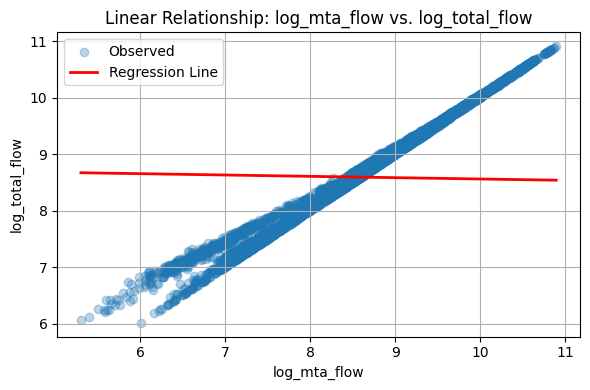


=== Plotting: log_taxi_flow ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


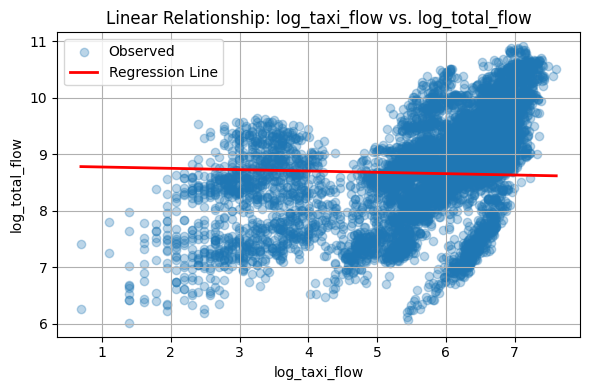


=== Plotting: fare_amount ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


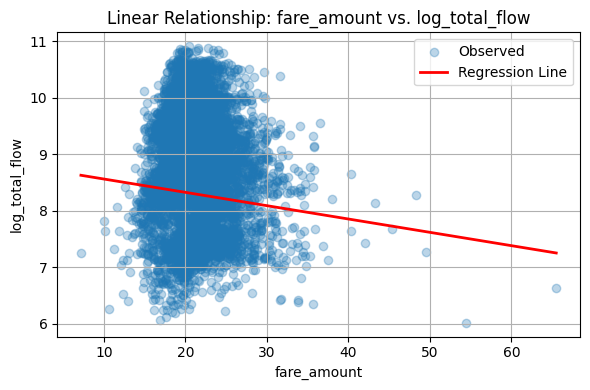


=== Plotting: has_congestion_surcharge ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


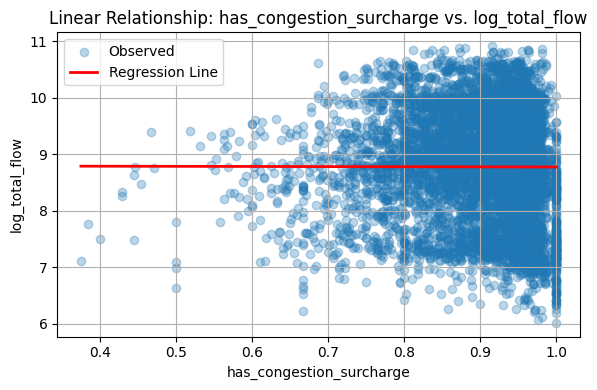


=== Plotting: lat ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


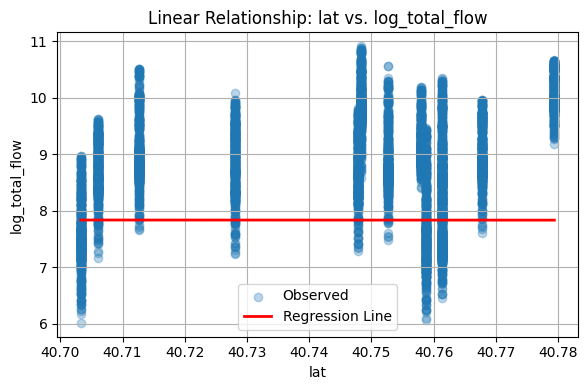


=== Plotting: lon ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


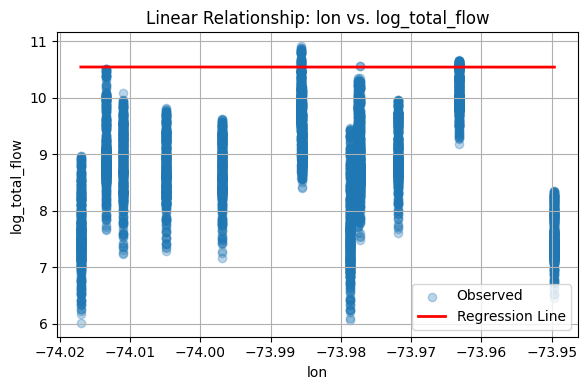


=== Plotting: zone_avg_flow ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


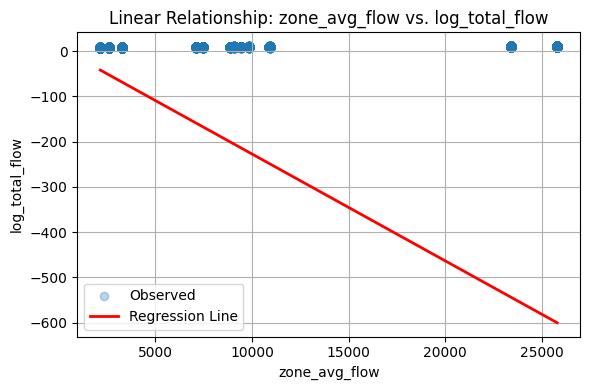


=== Plotting: temp ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


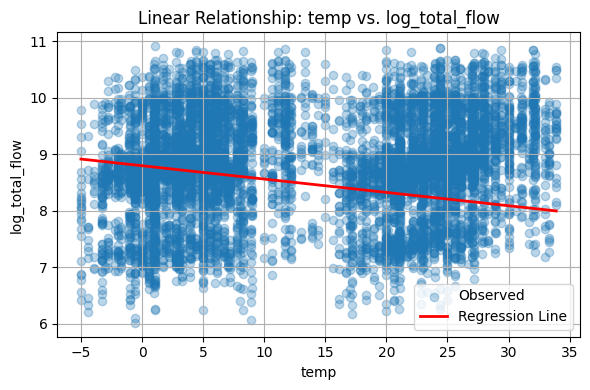


=== Plotting: prcp ===


c:\Users\mm921\anaconda3\envs\comp47360\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


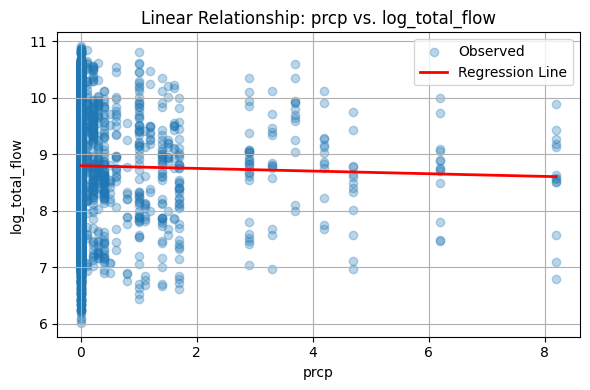

In [26]:
for feature in continuous_cols:
    print(f"\n=== Plotting: {feature} ===")
    X_feature = X_train_cont[[feature]]

    x_min = X_feature[feature].min()
    x_max = X_feature[feature].max()
    x_range = np.linspace(x_min, x_max, 100).reshape(-1, 1)
    y_pred = single_features_linreg.predict(x_range)


    plt.figure(figsize=(6, 4))
    plt.scatter(X_feature, y, alpha=0.3, label='Observed')
    plt.plot(x_range, y_pred, color='red', linewidth=2, label='Regression Line')

    plt.xlabel(feature)
    plt.ylabel('log_total_flow')
    plt.title(f"Linear Relationship: {feature} vs. log_total_flow")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<mark>Conclusion</mark>
1. Core feature `log_mta_flow`
2. Supporting features: `log_taxi_flow, fare_amount` have some influence and can be combined with other features.
3. Further processing: has_congestion_surcharge, geographic (lat, lon) and meteorological (temp, prcp) variables, weak linear effect alone.
4. Data checking: Pay special attention to how has_congestion_surcharge data is defined and aggregated.

##### 1-2-3 Multiple features

In [27]:
# Use more features for training
# Train aka fit, a model using all continuous features.

multiple_features_linreg = LinearRegression().fit(X_train_cont[continuous_cols], y)

# Print the weights learned for each feature.
print("Features: \n", continuous_cols)
print("Coeficients: \n", multiple_features_linreg.coef_)
print("\nIntercept: \n", multiple_features_linreg.intercept_)

feature_importance = pd.DataFrame({'feature': continuous_cols, 'importance':multiple_features_linreg.coef_})
feature_importance.sort_values('importance', ascending=False)

Features: 
 ['log_mta_flow', 'log_taxi_flow', 'fare_amount', 'has_congestion_surcharge', 'lat', 'lon', 'zone_avg_flow', 'temp', 'prcp']
Coeficients: 
 [ 8.90117386e-01  7.55541667e-02  2.72565664e-03  4.25356860e-02
 -1.21101087e+00  7.82369853e-01  1.49100448e-06 -3.63723732e-05
 -8.53857563e-04]

Intercept: 
 107.7261905641337


,feature,importance
0,log_mta_flow,0.890117
5,lon,0.782370
1,log_taxi_flow,0.075554
3,has_congestion_surcharge,0.042536
2,fare_amount,0.002726
6,zone_avg_flow,0.000001
7,temp,-0.000036
8,prcp,-0.000854
4,lat,-1.211011


In [28]:
# Predicted scores for each example.
multiple_features_linreg_predictions = multiple_features_linreg.predict(X_train_cont[continuous_cols])

actual_vs_multiple_features_linreg_predictions = pd.concat([y, pd.DataFrame(multiple_features_linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)
actual_vs_multiple_features_linreg_predictions

,log_total_flow,Predicted
0,9.317579,9.312108
1,8.869961,8.887561
2,10.114154,10.088454
3,8.403352,8.284739
4,7.638198,7.583740
...,...,...
7665,8.505525,8.537536
7666,8.567126,8.588706
7667,6.792344,6.883857
7668,9.274160,9.294392


<mark>Analysis</mark>
1. Key findings:

- log_mta_flow has the strongest positive impact on the target.

- Longitude (lon) also shows significant influence, while latitude (lat) has a negative effect, indicating complex spatial relationships.

- Other features such as log_taxi_flow and has_congestion_surcharge have smaller but positive contributions.

- Weather-related features (temp, prcp) and zone_avg_flow have minimal impact in this model.

2. Model performance:

- The multi-feature model shows improved prediction accuracy compared to single-feature models, effectively combining information from multiple variables.

3. Next steps:

- Incorporate categorical features such as time (hour, weekday) and zone identifiers.

- Explore regularization techniques (Lasso, Ridge) to improve feature selection and prevent overfitting.

- Experiment with nonlinear models (Random Forest, XGBoost) to capture complex feature interactions.

- Perform thorough model evaluation with cross-validation and multiple metrics.

In [29]:
y_true_log = y
y_pred_log = multiple_features_linreg.predict(X_train_cont[continuous_cols])

mae_log = mean_absolute_error(y_true_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
r2_log = r2_score(y_true_log, y_pred_log)

print(f"MAE (log scale): {mae_log:.4f}")
print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R2 (log scale): {r2_log:.4f}")

#log--> exp
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"\nMAE (original scale): {mae_orig:.4f}")
print(f"RMSE (original scale): {rmse_orig:.4f}")

MAE (log scale): 0.0431
RMSE (log scale): 0.0642
R2 (log scale): 0.9950

MAE (original scale): 285.8126
RMSE (original scale): 476.6244


In [30]:
print("log_total_flow min:", y.min())
print("log_total_flow max:", y.max())

y_orig = np.exp(y)
print("total_flow min:", y_orig.min())
print("total_flow max:", y_orig.max())

log_total_flow min: 6.016157159698354
log_total_flow max: 10.915433859104379
total_flow min: 410.00000000000017
total_flow max: 55018.99999999996


<mark>Observation</mark>

Look into the overall result of taking multiple continuous features to our target

| Metric        | Multiple Features Model(continuous features)  |
|--------------|-------------------------------------------------------------------|
| MAE     | 0.0431                                                         |
| RMSE    | 0.0642                                                        |
| R2       | 0.995%                                                             |

#### 1-3 categorical features

In [31]:
y = train_df['log_total_flow']

print("\nDescriptive features in X:\n", X_test_cat)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
        hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  \
7670     False    False    False    False    False    False    False    False   
7671     False    False    False    False    False    False    False    False   
7672     False    False    False    False    False    False    False    False   
7673     False    False    False    False    False    False    False    False   
7674     False    False    False    False    False    False    False    False   
...        ...      ...      ...      ...      ...      ...      ...      ...   
15595    False    False    False    False    False    False    False    False   
15596    False    False    False    False    False    False    False    False   
15597    False    False    False    False    False    False    False    False   
15598    False    False    False    False    False    False    False    False   
15599    False    False    False    False    False    False    False    False   

##### 1-3-1 multiple features

In [32]:
multiple_features_linreg = LinearRegression().fit(X_train_cat[categorical_cols], y)

# Print the weights learned for each feature.
print("Features: \n", categorical_cols)
print("Coeficients: \n", multiple_features_linreg.coef_)
print("\nIntercept: \n", multiple_features_linreg.intercept_)

feature_importance = pd.DataFrame({'feature': categorical_cols, 'importance':multiple_features_linreg.coef_})
feature_importance.sort_values('importance', ascending=False)

Features: 
 ['hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_6', 'coco_group_Cloudy/Overcast', 'coco_group_Fog/Low-Vis', 'coco_group_Heavy Rain', 'coco_group_Heavy Snow/Sleet', 'coco_group_Rain', 'coco_group_Snow/Sleet', 'coco_group_Unknown', 'is_weekend_1', 'zone_id_1', 'zone_id_2', 'zone_id_3', 'zone_id_4', 'zone_id_5', 'zone_id_6', 'zone_id_7', 'zone_id_8', 'zone_id_9', 'zone_id_10', 'zone_id_11', 'zone_id_12']
Coeficients: 
 [-0.08082411  0.03513766  0.17925973  0.29547906  0.48004485  0.70433328
  0.89344428  1.07720559  0.82971104  0.16600239  0.16337124  0.17099419
  0.07577081 -0.01736086 -0.20758798  0.06182923  0.00236761 -0.05436585
  0.04254307 -0.51694987 -0.02194483  0.0465629   0.0702617  -0.22494883
 -0.16509899  0.73584742 -0.45110037 -1.54070502 -1.45906622 -0.10555416
  0.89549455 -0.2821495  -0.20976966 -1.6421496  -0.28165663 -0.42

,feature,importance
7,hour_17,1.077206
30,zone_id_7,0.895495
6,hour_16,0.893444
8,hour_18,0.829711
25,zone_id_2,0.735847
5,hour_15,0.704333
4,hour_14,0.480045
3,hour_13,0.295479
2,hour_12,0.179260
11,weekday_3,0.170994


| features                    | cor           | interpretation                   |
| ----------------------- | ------------- | ----------------------- |
| `hour_17`               | **+1.0772**   | Highest traffic at 5pm, strong positive correlation          |
| `zone_id_7`             | +0.8955       | High traffic flow in this area, high activity hotspot           |
| `hour_16/18`            | +0.83\~0.89 | Traffic volume rises naturally in the evening peak period            |
| `hour_15`               | +0.7043       | Traffic is also high               |
| `hour_14/13`            | +0.48 / +0.29 | The trend is obvious from afternoon onwards             |
| `zone_id_2`             | +0.7358       | High traffic in specific areas                |
| `weekday_1~3`           | +0.16\~0.17 | Steady positive traffic from Monday to Wednesday             |
| `coco_group_Unknown`    | +0.0703       | May indicate that traffic does not drop during missing weather or other implied conditions |
| `coco_group_Snow/Sleet` | +0.0466       | In a few cases, snow has not significantly reduced traffic   |

| features                    | cor           | interpretation                   |
| ----------------------------- | -------------- | --------------- |
| `zone_id_10`                  | **-1.6421**    | Significantly low traffic in the area） |
| `zone_id_4/5`                 | -1.45        | Very low traffic areas         |
| `coco_group_Heavy Snow/Sleet` | -0.5170        | Heavy snowfall has significant negative impact on traffic flow    |
| `is_weekend_1`                | -0.2250        | Significantly lower weekend traffic        |
| `weekday_6`                   | -0.208         | Lower traffic on Saturdays         |
| `zone_id_3/8/12`              | -0.42\~-0.45 | All low activity areas         |
| `coco_group_Fog/Low-Vis`      | -0.0544        | Poor visibility decreases traffic        |


In [33]:
# Predicted scores for each example.
multiple_features_linreg_predictions = multiple_features_linreg.predict(X_train_cat[categorical_cols])

actual_vs_multiple_features_linreg_predictions = pd.concat([y, pd.DataFrame(multiple_features_linreg_predictions, columns=['Predicted'], index=y.index)], axis=1)
actual_vs_multiple_features_linreg_predictions

,log_total_flow,Predicted
0,9.317579,8.907337
1,8.869961,8.742238
2,10.114154,9.643184
3,8.403352,8.456236
4,7.638198,7.366632
...,...,...
7665,8.505525,8.953372
7666,8.567126,9.025752
7667,6.792344,7.593372
7668,9.274160,8.953865


In [34]:
y_true_log = y
y_pred_log = multiple_features_linreg.predict(X_train_cat[categorical_cols])

mae_log = mean_absolute_error(y_true_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
r2_log = r2_score(y_true_log, y_pred_log)

print(f"MAE (log scale): {mae_log:.4f}")
print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R2 (log scale): {r2_log:.4f}")

#log--> exp
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"\nMAE (original scale): {mae_orig:.4f}")
print(f"RMSE (original scale): {rmse_orig:.4f}")

MAE (log scale): 0.1856
RMSE (log scale): 0.2439
R2 (log scale): 0.9283

MAE (original scale): 1764.9862
RMSE (original scale): 3089.1955


<mark>Observation</mark>

| Metric        | Multiple Features Model(cont features)  | Multiple Features Model(cat features)  | Original Scale |
|--------------|-------------------------------------------------------------------|-------------------------|------|
| MAE     | 0.0431                                                         | 0.1856|1764.99 |
| RMSE    | 0.0642                                                        |0.2439|3089.2 |
| R2       | 0.995                                                             | 0.9283| - |

1. Categorical-only model

- R² = 0.9283 is decent but notably lower than the continuous-only R² (0.9950).

- Errors on the original scale (MAE ≈1,765, RMSE ≈3,089) are much larger than with continuous predictors (MAE ≈286, RMSE ≈477).

Indicates that while time‐of‐day, zone, and weather categories carry signal, they cannot by themselves capture the fine‐grained variation in flow.

2. Continuous-only model

- Strongly outperforms categorical‐only: very high R² and small errors.

- Traffic flow predictors (log_mta_flow, log_taxi_flow) dominate, with spatial and weather signals adding marginally.

3. Next steps

- Combine continuous and categorical features to leverage both fine‐grained flow signals and systematic patterns (time, zone, weather).

- Apply regularization (Ridge/Lasso) to manage the large number of one‐hot features and avoid overfitting.

- Evaluate final model using MAE, RMSE, and R² on a hold‐out test set to confirm real‐world performance.

- This combined approach should yield the lowest prediction errors and highest explained variance.

#### 1-4 All features

In [35]:
all_features_linreg = LinearRegression().fit(X_train_all[all_cols], y)

# Print the weights learned for each feature.
print("Features: \n", all_cols)
print("Coeficients: \n", all_features_linreg.coef_)
print("\nIntercept: \n", all_features_linreg.intercept_)

feature_importance = pd.DataFrame({'feature': all_cols, 'importance':all_features_linreg.coef_})
feature_importance.sort_values('importance', ascending=False)

Features: 
 ['log_mta_flow', 'log_taxi_flow', 'fare_amount', 'has_congestion_surcharge', 'lat', 'lon', 'zone_avg_flow', 'temp', 'prcp', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_6', 'coco_group_Cloudy/Overcast', 'coco_group_Fog/Low-Vis', 'coco_group_Heavy Rain', 'coco_group_Heavy Snow/Sleet', 'coco_group_Rain', 'coco_group_Snow/Sleet', 'coco_group_Unknown', 'is_weekend_1', 'zone_id_1', 'zone_id_2', 'zone_id_3', 'zone_id_4', 'zone_id_5', 'zone_id_6', 'zone_id_7', 'zone_id_8', 'zone_id_9', 'zone_id_10', 'zone_id_11', 'zone_id_12']
Coeficients: 
 [ 8.77263126e-01  6.41919706e-02  2.27126326e-04 -3.43754218e-02
 -4.28597838e-03 -1.58440943e-03  2.33119276e-06  3.13922626e-04
 -2.31379121e-03 -1.22567678e-02 -9.16984906e-03 -5.69147058e-03
 -2.75156450e-03  4.57616586e-03  1.61756112e-02  2.76947265e-02
  4.00254795e-02  1.98622397e-02  1.06835438e-02

,feature,importance
0,log_mta_flow,0.877263
37,zone_id_5,0.133054
35,zone_id_3,0.104703
1,log_taxi_flow,0.064192
16,hour_17,0.040025
15,hour_16,0.027695
34,zone_id_2,0.019968
17,hour_18,0.019862
39,zone_id_7,0.019299
14,hour_15,0.016176


In [36]:
y_true_log = y
y_pred_log = all_features_linreg.predict(X_train_all[all_cols])

mae_log = mean_absolute_error(y_true_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
r2_log = r2_score(y_true_log, y_pred_log)

print(f"MAE (log scale): {mae_log:.4f}")
print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R2 (log scale): {r2_log:.4f}")

#log--> exp
y_true_orig = np.exp(y_true_log)
y_pred_orig = np.exp(y_pred_log)

mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"\nMAE (original scale): {mae_orig:.4f}")
print(f"RMSE (original scale): {rmse_orig:.4f}")

MAE (log scale): 0.0223
RMSE (log scale): 0.0369
R2 (log scale): 0.9984

MAE (original scale): 183.1307
RMSE (original scale): 346.7375


<mark>Analysis</mark>

Predictive Accuracy

| Metric        |all | Multiple Features Model(cont features)  | Multiple Features Model(cat features)  | Original Scale |
|-------------- |--|-------------------------------------------------------------------|-------------------------|------|
| MAE     |0.0223 | 0.0431                                                         | 0.1856|1764.99 |
| RMSE    | 0.03690.0642                                                        |0.2439|3089.2 |
| R2       | 0.9984 |0.995                                                             | 0.9283| - |


1. Dominant Predictors

- log_mta_flow remains by far the strongest predictor (≈88% importance).

- Geographic zones (zone_id_5, zone_id_3, etc.) also contribute significantly, reflecting spatial hotspots.

- log_taxi_flow retains a solid secondary role, capturing complementary traffic signals.

2. Temporal Signals

- Peak‐hour indicators (e.g., hour_17) still matter but less so once flow measurements are included.

3. Weather & Weekend Effects

- Weather groups and weekend flag have very small coefficients, suggesting their marginal role once actual flow counts are known.

4. Error Context

- 183 vehicles MAE on an original‐scale range (~410–55 018) is ~0.4% average deviation—excellent for operational forecasting.

- Residual error is likely concentrated at very low‐flow or extremely high‐flow extremes; overall predictions are highly precise.

5. Next Steps

- Validate on hold-out/test set to confirm that this near-perfect fit generalizes.

- Inspect residuals for any systematic biases at the tails (very low or very high flows).

- Consider model regularization (Ridge/Lasso) to guard against over-reliance on any single zone or time dummy.

#### 1-5 Validation

In [37]:
# 1. model
# all_features_linreg

# 2. test
y_pred_test_log = all_features_linreg.predict(X_test_all)

# 3.
mae_test_log  = mean_absolute_error(y_test, y_pred_test_log)
rmse_test_log = np.sqrt(mean_squared_error(y_test, y_pred_test_log))
r2_test_log   = r2_score(y_test, y_pred_test_log)

print(f"Test MAE (log scale):  {mae_test_log:.4f}")
print(f"Test RMSE (log scale): {rmse_test_log:.4f}")
print(f"Test R2 (log scale):   {r2_test_log:.4f}")

# 4. 
y_test_orig      = np.exp(y_test)
y_pred_test_orig = np.exp(y_pred_test_log)

mae_test_orig  = mean_absolute_error(y_test_orig, y_pred_test_orig)
rmse_test_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))

print(f"\nTest MAE (original):  {mae_test_orig:.1f}")
print(f"Test RMSE (original): {rmse_test_orig:.1f}")

Test MAE (log scale):  0.0285
Test RMSE (log scale): 0.0511
Test R2 (log scale):   0.9968

Test MAE (original):  254.1
Test RMSE (original): 557.0


In [38]:
# Define custom scorers
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)             # negate so higher is “better”
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer  = make_scorer(r2_score)

# Use KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(
    all_features_linreg,                # your fitted or unfitted LinearRegression()
    X_train_all, y_train,           # training data
    cv=kf,
    scoring={'MAE': mae_scorer,
             'MSE': mse_scorer,
             'R2':  r2_scorer},
    return_train_score=False
)

# Extract and convert MSE → RMSE
mae_scores = -results['test_MAE']
rmse_scores = np.sqrt(-results['test_MSE'])
r2_scores  =  results['test_R2']

print("5-Fold CV Results:")
print(f" MAE:  {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
print(f" RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
print(f" R2:   {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

5-Fold CV Results:
 MAE:  0.0224 ± 0.0007
 RMSE: 0.0372 ± 0.0013
 R2:   0.9983 ± 0.0001


In [39]:
# create model
# model_cont = LinearRegression()
# model_cat = LinearRegression()

# model_cont.fit(X_cont_train, y_train)
# model_cat.fit(X_cat_train, y_train)

In [40]:
#要還原預測值
# 合併預測(con + cat)
# pred_log_combined = (pred_log_cont + pred_log_cat) / 2
# y_pred = np.expm1(log_preds)
# y_true = np.expm1(y_test)

In [41]:
#pkl
import joblib

model_filename = "linreg_model.pkl"
joblib.dump(all_features_linreg, model_filename)

print(f"Model saved to {model_filename}")

Model saved to linreg_model.pkl


In [42]:
# frontend
# send [zone_id, hour, weekday] to backend
# backend deal with data by one-hot
# use model.pkl
# get log_total then use exp() return to predicted_total_flow

In [43]:
#backend
# from flask import Flask, request, jsonify
# import pandas as pd

# baseline = pd.read_csv("baseline.csv")  # 有 weekday, hour, zone_id, total_flow

# app = Flask(__name__)

# @app.route("/busyness", methods=["POST"])
# def busyness():
#     data = request.get_json()
#     wd   = data['weekday']
#     hr   = data['hour']
#     zid  = data['zone_id']
#     # optional: current sensor values
#     curr_mta  = data.get('current_mta_flow', None)
#     curr_taxi = data.get('current_taxi_flow', None)

#     row = baseline.query(
#         "weekday==@wd and hour==@hr and zone_id==@zid"
#     ).iloc[0]
#     avg_total = row['total_flow']

#     if curr_mta is not None and curr_taxi is not None:
#         curr_total = curr_mta + curr_taxi
#         busy_index = curr_total / avg_total
#         level = (
#             "Very Busy"   if busy_index>1.2 else
#             "Busy"        if busy_index>1.0 else
#             "Normal"      if busy_index>0.8 else
#             "Not Busy"
#         )
#         return jsonify({
#             "avg_total_flow":   avg_total,
#             "current_total":    curr_total,
#             "busy_index":       busy_index,
#             "level":            level
#         })
#     else:
#         # no real-time, just return baseline
#         return jsonify({
#             "predicted_total_flow": avg_total
#         })

# if __name__=="__main__":
#     app.run()

In [44]:
# 1. ratio
# busy_index = predicted_total_flow / avg_total_flow

# 2.
# busy_score = busy_index * 100
# busy_score = max(0, min(busy_score, 100))
# busy_score = round(busy_score, 1)

# 3. return
# return jsonify({
#     "predicted_total_flow": predicted_total_flow,
#     "avg_total_flow":      avg_total_flow,
#     "busy_score":          busy_score
# })

In [45]:
# Algo suggestion1
# use zone + hour + weekday historical data flow, calculate the weight
# hist = df.groupby(['zone_id','hour','weekday'])['total_flow']
# stats = hist.agg(['mean','std']).reset_index().rename(columns={'mean':'μ','std':'σ'})
# df = df.merge(stats, on=['zone_id','hour','weekday'])
# df['busy_z'] = (df['pred_flow'] - df['μ']) / df['σ']
# busy_z > 2 ==> very busy ; busy_z = 0 ==> normal ; busy_z < 0 ==> not busy

#could change into scale 0-100
# df['busy_pct_theoretical'] = norm.cdf(df['busy_z']) * 100

In [46]:
# Algo suggestion2

# 先把 historical total_flow 跟 pred_flow 都暫放在同一 group
# def compute_empirical_pct(group):
#     hist = group['total_flow'].values
#     # percentileofscore 預設是 “weak” 方法 (<=)，接近你要的意義
#     return group['pred_flow'].apply(lambda x: percentileofscore(hist, x))

# df['busy_pct_empirical'] = (
#     df.groupby(['zone_id','hour','weekday'])
#       .apply(compute_empirical_pct)
#       .reset_index(level=[0,1,2], drop=True)
# )

# 直接告訴你：當前預測比歷史上多少 % 時刻還要忙

# 完全靠觀察到的分佈，不假設常態

In [47]:
#TODO
#historical flow data in each time zone and mapping id
#mapping id for weather

In [54]:
X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, 7670 to 15599
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   log_mta_flow                 7930 non-null   float64
 1   log_taxi_flow                7930 non-null   float64
 2   fare_amount                  7930 non-null   float64
 3   has_congestion_surcharge     7930 non-null   float64
 4   lat                          7930 non-null   float64
 5   lon                          7930 non-null   float64
 6   zone_avg_flow                7930 non-null   float64
 7   temp                         7930 non-null   float64
 8   prcp                         7930 non-null   float64
 9   hour_10                      7930 non-null   bool   
 10  hour_11                      7930 non-null   bool   
 11  hour_12                      7930 non-null   bool   
 12  hour_13                      7930 non-null   bool   
 13  hour_14            

In [ ]:
import joblib

model = joblib.load('linreg_model.pkl')

if hasattr(model, 'feature_names_in_'):
    print(model.feature_names_in_)

['log_mta_flow' 'log_taxi_flow' 'fare_amount' 'has_congestion_surcharge'
 'lat' 'lon' 'zone_avg_flow' 'temp' 'prcp' 'hour_10' 'hour_11' 'hour_12'
 'hour_13' 'hour_14' 'hour_15' 'hour_16' 'hour_17' 'hour_18' 'weekday_1'
 'weekday_2' 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'month_6'
 'coco_group_Cloudy/Overcast' 'coco_group_Fog/Low-Vis'
 'coco_group_Heavy Rain' 'coco_group_Heavy Snow/Sleet' 'coco_group_Rain'
 'coco_group_Snow/Sleet' 'coco_group_Unknown' 'is_weekend_1' 'zone_id_1'
 'zone_id_2' 'zone_id_3' 'zone_id_4' 'zone_id_5' 'zone_id_6' 'zone_id_7'
 'zone_id_8' 'zone_id_9' 'zone_id_10' 'zone_id_11' 'zone_id_12']


In [58]:
df3 = df2.copy()

### historical data (For Backend)

In [67]:
from datetime import datetime, timedelta


start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 12, 31)
hours = list(range(9, 18))

records = []
for single_date in pd.date_range(start_date, end_date):
    for hour in hours:
        for zone in range(13):  # 13 zone_id
            records.append({
                'date': single_date.date(),
                'hour': hour,
                'weekday': single_date.weekday(),  # 0=Mon
                'zone_id': zone
            })

df_hist = pd.DataFrame(records)

In [68]:
flow_avg = pd.read_csv('historical_average_flow_by_zone_hour.csv')
df_hist = df_hist.merge(flow_avg, on=['zone_id', 'weekday', 'hour'], how='left')

# get log
df_hist['log_mta_flow'] = np.log1p(df_hist['mta_flow'])
df_hist['log_taxi_flow'] = np.log1p(df_hist['taxi_flow'])

In [69]:
zone_info = pd.read_csv('zone_id_name_latlon_mapping.csv')
df_hist = df_hist.merge(zone_info[['zone_id', 'lat', 'lon']], on='zone_id', how='left')

In [70]:
print(df_hist.columns)

Index(['date', 'hour', 'weekday', 'zone_id', 'mta_flow', 'taxi_flow',
       'log_mta_flow', 'log_taxi_flow', 'lat', 'lon'],
      dtype='object')


In [72]:
df_dummy = pd.get_dummies(
    data=df_hist,
    columns=['hour', 'weekday', 'zone_id'],
    prefix=['hour', 'weekday', 'zone_id']
)

with open('linreg_model.pkl', 'rb') as f:
    import joblib
    model = joblib.load(f)
    model_features = model.feature_names_in_

for col in model_features:
    if col not in df_dummy.columns and col not in df_hist.columns:
        df_dummy[col] = False

df_input = pd.concat([df_hist, df_dummy], axis=1)

df_input_final = df_input[list(model_features)]

In [73]:
df_input_final.to_csv("historical_input_for_prediction.csv", index=False)